In [1]:
#Usual Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data Wrangling
We perform the data wrangling steps previously detailed in the Data Story step.

In [2]:
billboard_data = pd.read_csv("all_charts.csv",low_memory=False)
spotify_data = pd.read_csv("audio_features.csv")
billboard_lyrics = pd.read_csv("all_lyrics.csv",encoding='latin1')
billboard_sub = billboard_data[["chartDate","title","artist","peakPos","lastPos","weeks","rank","change","spotifyID"]]
spotify_sub = spotify_data[["acousticness", "danceability", "duration_ms", "energy", "id","instrumentalness", "key", "liveness", "loudness", "mode", "speechiness", "tempo", "time_signature","valence"]]
merged_data=pd.merge(billboard_sub,spotify_sub, how="outer",left_on="spotifyID",right_on="id")
#Replace weird characters:
merged_data=merged_data.replace({'\x83': '?'}, regex=True).replace({'\x82': '?'}, regex=True).replace({'\x80\x9c': '??'}, regex=True)
lyrics_sub=billboard_lyrics[["artist","lyrics","track","source"]]
big_dataset=pd.merge(merged_data, lyrics_sub,  how="outer",left_on=["artist","title"],right_on=["artist", "track"])
year = big_dataset.chartDate.replace({'-': ''}, regex=True)
year = year.apply(np.float)
year = year//10000
pd.set_option('precision', 0)
year=year.rename("year")
year_data=pd.concat([big_dataset,year],axis=1)

# Song Popularity Prediction
For the purposes of this project we say that a song is popular if it reaches the top ten, this is given by songs with 'peakPos'<=10. We separate the songs into two categories and then keep only the songs for which we have Spotify audio metadata. Here, we use a binary classifier in the 'top_ten_hit' column.

In [3]:
group_columns = ["title","artist","peakPos",'acousticness','danceability','duration_ms','energy','instrumentalness','key','liveness','loudness','mode','speechiness','tempo','time_signature','valence','year']
search_data=year_data.groupby(group_columns).size().reset_index()
search_data.head()

,title,artist,peakPos,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,year,0
0,"""B"" Girls",Young And Restless,54,2e-02,6e-01,242107,5e-01,0e+00,7,3e-01,-12,1,4e-01,194,3,8e-01,1990,15
1,#1,Nelly,22,2e-02,8e-01,198773,6e-01,0e+00,7,4e-01,-6,1,2e-01,90,4,5e-01,2001,11
2,#1,Nelly,22,2e-02,8e-01,198773,6e-01,0e+00,7,4e-01,-6,1,2e-01,90,4,5e-01,2002,9
3,#Beautiful,Mariah Carey Featuring Miguel,15,5e-01,7e-01,202027,7e-01,3e-06,4,2e-01,-7,1,4e-02,107,4,5e-01,2013,16
4,#SELFIE,The Chainsmokers,16,1e-02,8e-01,183750,9e-01,9e-06,0,8e-02,-3,1,2e-01,128,4,7e-01,2014,11


In [4]:
len(search_data)

27178

Note that grouping the columns in the way above will create duplicates for songs that charted in multiple years. To avoid this we subset by the first year the song charted.

In [5]:
top_ten_yearly=search_data.groupby(["title","artist","peakPos",'acousticness','danceability','duration_ms','energy','instrumentalness','key','liveness','loudness','mode','speechiness','tempo','time_signature','valence']).min().reset_index()
len(top_ten_yearly)

22155

In [6]:
# Create the top_ten_hit predictor column.
top_ten_prediction=top_ten_yearly[['peakPos', 'acousticness','danceability','duration_ms','energy','instrumentalness','key','liveness','loudness','mode','speechiness','tempo','time_signature','valence','year']]
top_ten_prediction['top_ten_hit']= (top_ten_prediction.peakPos < 11).astype(int)

C:\Users\MSI_USER\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [7]:
top_ten_prediction.groupby(['top_ten_hit']).mean().reset_index()

,top_ten_hit,peakPos,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,year
0,0,53,3e-01,6e-01,219176,6e-01,4e-02,5,2e-01,-9,7e-01,7e-02,12,4,6e-01,1985
1,1,5,3e-01,6e-01,225437,6e-01,4e-02,5,2e-01,-9,7e-01,6e-02,12,4,6e-01,1983


From this initial investigation it seems like there is very little difference between the audio metadata features between songs making the Top Ten and songs that do not. However, from our previous observations of the averages over time we know that for certain years the averages between top ten hits and songs in the bottom ninety can differ significantly.

In [8]:
top_ten_prediction.groupby(['year','top_ten_hit']).mean().reset_index()

,year,top_ten_hit,peakPos,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,1958,0,52,7e-01,5e-01,147195,5e-01,7e-02,5,2e-01,-11,8e-01,5e-02,117,4,7e-01
1,1958,1,5,6e-01,6e-01,149220,5e-01,9e-02,5,2e-01,-10,9e-01,6e-02,119,4,7e-01
2,1959,0,54,7e-01,5e-01,149766,5e-01,9e-02,5,2e-01,-11,9e-01,5e-02,114,4,7e-01
3,1959,1,5,6e-01,6e-01,149480,5e-01,6e-02,5,2e-01,-11,8e-01,5e-02,121,4,7e-01
4,1960,0,53,7e-01,5e-01,151907,5e-01,6e-02,5,2e-01,-11,9e-01,5e-02,118,4,7e-01
5,1960,1,5,7e-01,5e-01,160218,4e-01,9e-02,5,2e-01,-11,8e-01,4e-02,119,4,7e-01
6,1961,0,53,7e-01,5e-01,154480,5e-01,7e-02,5,2e-01,-11,9e-01,6e-02,120,4,7e-01
7,1961,1,5,6e-01,6e-01,153698,4e-01,8e-02,5,2e-01,-12,9e-01,5e-02,122,4,7e-01
8,1962,0,57,6e-01,5e-01,158169,5e-01,7e-02,5,2e-01,-11,9e-01,6e-02,118,4,7e-01
9,1962,1,5,6e-01,6e-01,158012,5e-01,7e-02,6,2e-01,-10,8e-01,6e-02,119,4,7e-01


# Data Visualization

The key variable is an integer between zero and eleven and time signature is an integer between 2 and 5. These are not on a numerical scale so we introduce dummy indicator variables to distinguish between the cases when using linear regression.

In [9]:
# create dummy variables using get_dummies, then exclude the first dummy column
key_dummies = pd.get_dummies(top_ten_prediction.key, prefix='key').iloc[:, 1:]
time_dummies = pd.get_dummies(top_ten_prediction.time_signature, prefix='time').iloc[:, 1:]
# concatenate the dummy variable columns onto the original DataFrame (axis=0 means rows, axis=1 means columns)
top_ten_no_na_dum = pd.concat([top_ten_prediction, key_dummies,time_dummies], axis=1)

We check the histograms to see how they are distributed.

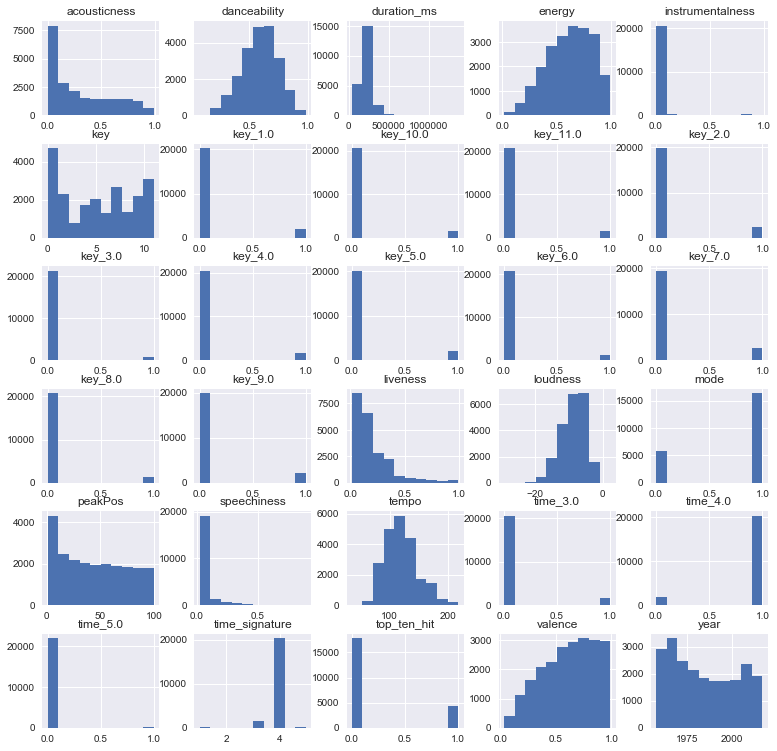

In [10]:
# Univariate Histograms
top_ten_no_na_dum.hist(figsize=(13, 13))
plt.show()

We've already discussed these distributions in the data story. We also perform a box and whiskers plot.

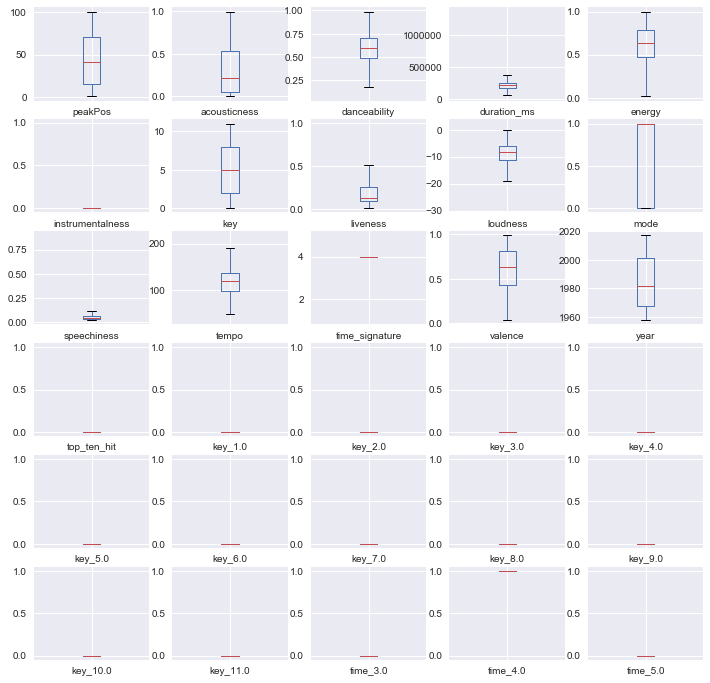

In [11]:
top_ten_no_na_dum.plot(kind='box', subplots=True,layout=(6,5), figsize=(12, 12), sharex=False, sharey=False)
plt.show()

From this we see there are a few outliers for the duration variable. We also look at the correlation matrices for the variables.

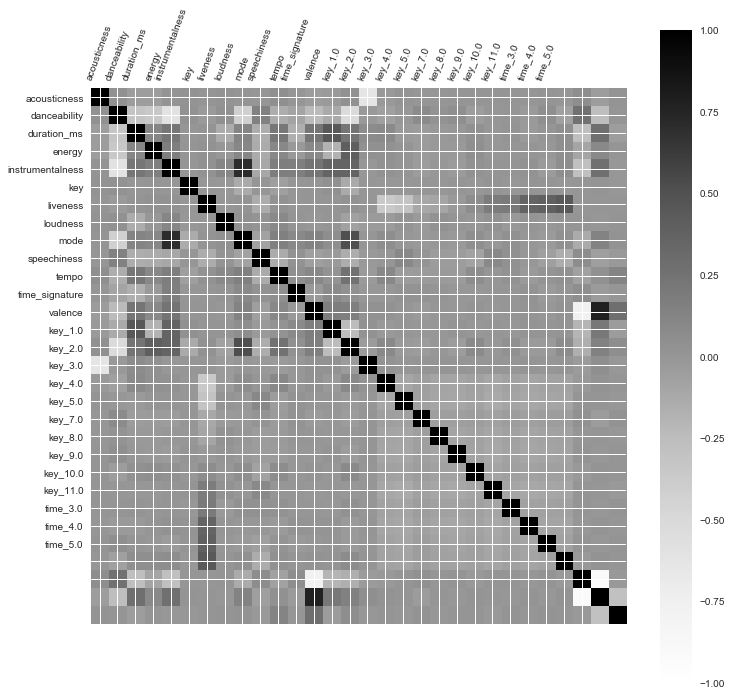

In [12]:
correlations = top_ten_no_na_dum.corr()
# plot correlation matrix
fig = plt.figure(figsize=(12, 12))
names=linear_feature_cols = ['acousticness','danceability','duration_ms','energy','instrumentalness','key','liveness','loudness','mode','speechiness','tempo','time_signature','valence','key_1.0','key_2.0','key_3.0','key_4.0','key_5.0','key_7.0','key_8.0','key_9.0','key_10.0','key_11.0','time_3.0','time_4.0','time_5.0']
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,28,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(names,rotation=70)
ax.set_yticklabels(names)
plt.show()

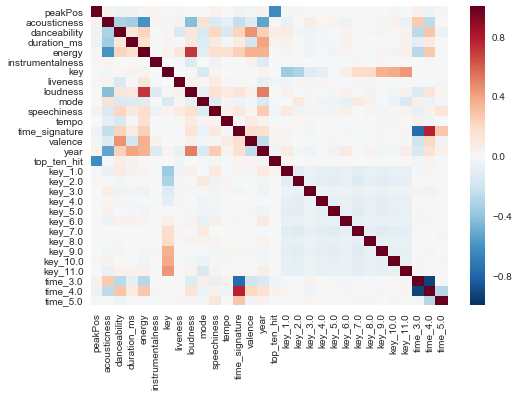

In [14]:
corr = top_ten_no_na_dum.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.show()

From this we see a high positive correlation between energy and loudness and high negative correlation between acousticness and both loudness and energy. 

# Machine Learning Modelling Phase

In [51]:
# Machine Learning Imports
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import r2_score

# Classificaiton Algorithms
We first create an algorithm using GridSearch to optimize the parameters in the cross-validation stage. We will initially use 5-fold cross-validation. 

In [16]:
# Given a set of hyperparameters and training data we use Grid Search to find the best choice of hyperparameters
def cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=5):
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(Xtrain, ytrain)
    print("BEST PARAMS", gs.best_params_)
    best = gs.best_estimator_
    return best

We write the following classification algorithm that we can use with multiple machine learning models given a dataset, target variable and hyperparameters.

In [17]:
# we use a 80-20 Train-Test split by default and do not standardize the audiodata metadata features
# We set the seed to 7 to obtain consistent results
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, standardize=False, train_size=0.8,seed = 7):
    #To create the 'X' dataset we first standardize by the mean and standard deviation is standardize is set to True
    subdf=indf[featurenames]
    if standardize:
        subdfstd=(subdf - subdf.mean())/subdf.std()
    else:
        subdfstd=subdf
    #Create the 'X' and 'y' datasets
    X=subdfstd.values
    y=(indf[targetname].values==target1val)*1
    #Split X and y into training and test data.
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=train_size,random_state=seed)
    #Now implement GridSearchCV for the cross validation steop 
    clf = cv_optimize(clf, parameters, Xtrain, ytrain)
    #Use the classifier to fit the training data
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print("Accuracy on training data: {:0.5f}".format(training_accuracy))
    print("Accuracy on test data:     {:0.5f}".format(test_accuracy))
    return clf, Xtrain, ytrain, Xtest, ytest

Since our question is primarily a binary classification problem, Linear Regression is not a recommended model to use so we begin with Logistic Regression.

In [18]:
linear_feature_cols= ['acousticness','danceability','duration_ms','energy','instrumentalness','liveness','loudness','speechiness','tempo','valence','year']

# Logistic Regression

In [19]:
from sklearn.linear_model import LogisticRegression
params = {"C": [0.001, 0.1, 1, 10, 100]}
clf_log, Xtrain_log, ytrain_log, Xtest_log, ytest_log  = do_classify(LogisticRegression(), 
                                                           params, 
                                                           top_ten_no_na_dum, linear_feature_cols, 'top_ten_hit',1)

BEST PARAMS {'C': 0.001}
Accuracy on training data: 0.80648
Accuracy on test data:     0.80275


In [21]:
ytrain_log.mean()

0.19346648612051456

19% of songs reach the Top Ten so we can obtain 81% accuracy by just guessing no all the time. Thus our logistic model does not improve upon guessing at all.

In [22]:
# pair the feature names with the coefficients
clf_log.coef_

array([[ -2.98048847e-07,  -3.58027701e-08,   1.42734492e-06,
         -2.89871219e-07,  -6.72755961e-08,  -2.08841511e-07,
          4.49492425e-06,  -6.95457428e-08,  -5.77115466e-05,
         -1.88202755e-07,  -8.76220772e-04]])

In [23]:
test_prediction_log=clf_log.predict(Xtest_log)
print(confusion_matrix(ytest_log,test_prediction_log))
print(classification_report(ytest_log,test_prediction_log))

[[3557    0]
 [ 874    0]]
             precision    recall  f1-score   support

          0       0.80      1.00      0.89      3557
          1       0.00      0.00      0.00       874

avg / total       0.64      0.80      0.71      4431



C:\Users\MSI_USER\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


** As we expect since predicting that every track will not reach the top ten will be correct 81% of the time, the logistic model uses this as its prediction model. **

# Ridge Regression

In [24]:
from sklearn.linear_model import Ridge
params = {'alpha':[0.1,1,10]}
clf_ridge, Xtrain_ridge, ytrain_ridge, Xtest_ridge, ytest_ridge  = do_classify(Ridge(), 
                                                           params, 
                                                           top_ten_no_na_dum, linear_feature_cols, 'top_ten_hit',1)
test_prediction_ridge=clf_ridge.predict(Xtest_ridge)
r2_score_ridge = r2_score( ytest_ridge, test_prediction_ridge)
print("r^2 on test data : %f" % r2_score_ridge)

BEST PARAMS {'alpha': 1}
Accuracy on training data: 0.01466
Accuracy on test data:     0.01380
r^2 on test data : 0.013798


In [28]:
#print(confusion_matrix(ytest_ridge,test_prediction_ridge))
#print(classification_report(ytest_ridge,test_prediction_ridge))

Here Ridge regression is a type of linear regression and not a very suitable model for binary classification problems.

# Lasso Regression Model

In [23]:
from sklearn.linear_model import Lasso
params ={"alpha":[1, 0.1,0.01,0.001]}
clf_lasso, Xtrain_lasso, ytrain_lasso, Xtest_lasso, ytest_lasso  = do_classify(Lasso(), 
                                                           params, 
                                                           top_ten_no_na_dum, linear_feature_cols, 'top_ten_hit',1)
y_pred_lasso = clf_lasso.fit(Xtrain_lasso, ytrain_lasso).predict(Xtest_lasso)
r2_score_lasso = r2_score( ytest_lasso, y_pred_lasso)
print("r^2 on test data : %f" % r2_score_lasso)

BEST PARAMS {'alpha': 0.001}
Accuracy on training data: 0.00831
Accuracy on test data:     0.00342
r^2 on test data : 0.003417


# Elastic Net Regression

BEST PARAMS {'alpha': 0.001, 'l1_ratio': 0.2}
Accuracy on training data: 0.01076
Accuracy on test data:     0.00503
r^2 on test data : 0.005027


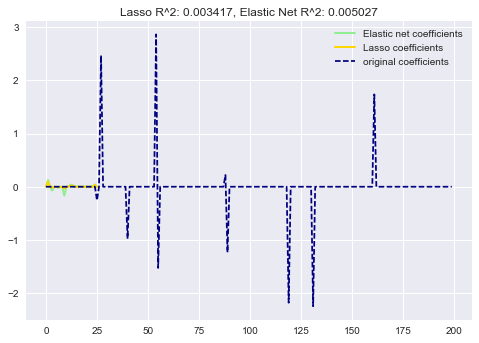

In [24]:
from sklearn.linear_model import ElasticNet
params ={"alpha":[1,0.1,0.01,0.001],
        'l1_ratio':[0.1,0.2,0.4]}
clf_enet, Xtrain_enet, ytrain_enet, Xtest_enet, ytest_enet  = do_classify(ElasticNet(), 
                                                           params, 
                                                           top_ten_no_na_dum, linear_feature_cols, 'top_ten_hit',1)
y_pred_enet = clf_enet.fit(Xtrain_enet, ytrain_enet).predict(Xtest_enet)
r2_score_enet = r2_score(ytest_enet, y_pred_enet)

print("r^2 on test data : %f" % r2_score_enet)

plt.plot(clf_enet.coef_, color='lightgreen', linewidth=2,
         label='Elastic net coefficients')
plt.plot(clf_lasso.coef_, color='gold', linewidth=2,
         label='Lasso coefficients')
n_samples, n_features = 50, 200
X = np.random.randn(n_samples, n_features)
coef = 3 * np.random.randn(n_features)
inds = np.arange(n_features)
np.random.shuffle(inds)
coef[inds[10:]] = 0 
plt.plot(coef, '--', color='navy', label='original coefficients')
plt.legend(loc='best')
plt.title("Lasso R^2: %f, Elastic Net R^2: %f"
          % (r2_score_lasso, r2_score_enet))
plt.show()

** Lasso Regression and Elastic Net Regression are similary do not produce accurate models. **

# Decision Tree

In [30]:
from sklearn.tree import DecisionTreeClassifier
feature_cols = ['acousticness','danceability','duration_ms','energy','instrumentalness','key','liveness','loudness','mode','speechiness','tempo','time_signature','valence','year']
params ={'criterion': ["gini","entropy"],
 'max_depth': [1,3, 10],
 'max_features': [1, 3, 10],
 'min_samples_leaf': [ 3,10],
 'min_samples_split': [3,10]}
clf_dtree, Xtrain_dtree, ytrain_dtree, Xtest_dtree, ytest_dtree  = do_classify(DecisionTreeClassifier(), 
                                                           params, 
                                                           top_ten_prediction, feature_cols, 'top_ten_hit',1)

BEST PARAMS {'criterion': 'gini', 'max_depth': 3, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 10}
Accuracy on training data: 0.80653
Accuracy on test data:     0.80275


In [31]:
test_prediction_dtree=clf_dtree.predict(Xtest_dtree)
print(confusion_matrix(ytest_dtree,test_prediction_dtree))
print(classification_report(ytest_dtree,test_prediction_dtree))

[[3557    0]
 [ 874    0]]
             precision    recall  f1-score   support

          0       0.80      1.00      0.89      3557
          1       0.00      0.00      0.00       874

avg / total       0.64      0.80      0.71      4431



C:\Users\MSI_USER\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


** Here the Decision Tree model does not improve on the trivial accuracy as we can see from the confusion matrix. **

# Random Forest

In [32]:
from sklearn.ensemble import RandomForestClassifier
params={'n_estimators':[500,1000]}
clf_rf, Xtrain_rf, ytrain_rf, Xtest_rf, ytest_rf  = do_classify(RandomForestClassifier(), 
                                                           params, 
                                                           top_ten_prediction, feature_cols, 'top_ten_hit',1)

BEST PARAMS {'n_estimators': 1000}
Accuracy on training data: 0.99746
Accuracy on test data:     0.80253


In [37]:
test_prediction_rf=clf_rf.predict(Xtest_rf)
print(confusion_matrix(ytest_rf,test_prediction_rf))
print(classification_report(ytest_rf,test_prediction_rf))

[[3539   18]
 [ 857   17]]
             precision    recall  f1-score   support

          0       0.81      0.99      0.89      3557
          1       0.49      0.02      0.04       874

avg / total       0.74      0.80      0.72      4431



In [33]:
ytrain_rf.mean()

0.19346648612051456

** We finally obtain a model different that the trivial one for prediction although we do not see any improvement in the accuracy. **

# Support Vector Classification

In [35]:
from sklearn.svm import SVC
params ={'C':[1],
 'cache_size':[200],
 'degree':[3],
 'gamma':['auto'], 
 'kernel':['rbf'],
 'max_iter':[-1],
 'tol':[0.001]}
clf_svc, Xtrain_svc, ytrain_svc, Xtest_svc, ytest_svc  = do_classify(SVC(), 
                                                           params, 
                                                           top_ten_prediction, feature_cols, 'top_ten_hit',1)

BEST PARAMS {'C': 1, 'cache_size': 200, 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf', 'max_iter': -1, 'tol': 0.001}
Accuracy on training data: 0.99599
Accuracy on test data:     0.80253


In [36]:
test_prediction_svc=clf_svc.predict(Xtest_svc)
print(confusion_matrix(ytest_svc,test_prediction_svc))
print(classification_report(ytest_svc,test_prediction_svc))

[[3542   15]
 [ 860   14]]
             precision    recall  f1-score   support

          0       0.80      1.00      0.89      3557
          1       0.48      0.02      0.03       874

avg / total       0.74      0.80      0.72      4431



** Support Vector classification also does not improve upon the trivial prediction. **

# KNN 

In [38]:
from sklearn.neighbors import KNeighborsClassifier
params ={}
clf_knn, Xtrain_knn, ytrain_knn, Xtest_knn, ytest_knn  = do_classify(KNeighborsClassifier(), 
                                                           params, 
                                                           top_ten_prediction, feature_cols, 'top_ten_hit',1)
test_prediction_knn=clf_knn.predict(Xtest_knn)
print(confusion_matrix(ytest_knn,test_prediction_knn))
print(classification_report(ytest_knn,test_prediction_knn))

BEST PARAMS {}
Accuracy on training data: 0.81979
Accuracy on test data:     0.76484
[[3334  223]
 [ 819   55]]
             precision    recall  f1-score   support

          0       0.80      0.94      0.86      3557
          1       0.20      0.06      0.10       874

avg / total       0.68      0.76      0.71      4431



** Here K-Nearest Neighbors gives a less accurate model than the trivial one. **

# Neural Network

In [39]:
from sklearn.preprocessing import StandardScaler
X=top_ten_prediction[feature_cols].values
y=top_ten_prediction['top_ten_hit'].values
Xtrain_nn, Xtest_nn, ytrain_nn, ytest_nn  = train_test_split(X, y, train_size=0.8,random_state=6)                                                          
scaler = StandardScaler()
# Fit only to the training data
scaler.fit(Xtrain_nn)
X_train_nn = scaler.transform(Xtrain_nn)
X_test_nn = scaler.transform(Xtest_nn)

Next we create an instance of the model, there are a lot of parameters you can choose to define and customize here, we will only define the hidden_layer_sizes. For this parameter you pass in a tuple consisting of the number of neurons you want at each layer, where the nth entry in the tuple represents the number of neurons in the nth layer of the MLP model. There are many ways to choose these numbers, but for simplicity we will choose 3 layers with the same number of neurons as there are features in our data set

In [42]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(16,16,16))
mlp.fit(X_train_nn,ytrain_nn)
training_accuracy = mlp.score(X_train_nn, ytrain_nn)
test_accuracy = mlp.score(X_test_nn, ytest_nn)
print("Accuracy on training data: {:0.5f}".format(training_accuracy))
print("Accuracy on test data:     {:0.5f}".format(test_accuracy))
predictions = mlp.predict(X_test_nn)
print(confusion_matrix(ytest_nn,predictions))
print(classification_report(ytest_nn,predictions))

Accuracy on training data: 0.80563
Accuracy on test data:     0.80952
[[3581   13]
 [ 831    6]]
             precision    recall  f1-score   support

          0       0.81      1.00      0.89      3594
          1       0.32      0.01      0.01       837

avg / total       0.72      0.81      0.73      4431



In [43]:
ytrain_nn.mean()

0.19555405100428797

Here we obtain a very slight improve on the trivial model. 

# GBM Tree

In [44]:
#Import libraries:
from sklearn.ensemble import GradientBoostingClassifier  #GBM algorithm
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

X = top_ten_no_na_dum[linear_feature_cols]
y = top_ten_no_na_dum['top_ten_hit']

Keeping all this in mind, we can take the following approach:

    Choose a relatively high learning rate. Generally the default value of 0.1 works but somewhere between 0.05 to 0.2 should work for different problems
    Determine the optimum number of trees for this learning rate. This should range around 40-70. Remember to choose a value on which your system can work fairly fast. This is because it will be used for testing various scenarios and determining the tree parameters.
    Tune tree-specific parameters for decided learning rate and number of trees. Note that we can choose different parameters to define a tree and I’ll take up an example here.
    Lower the learning rate and increase the estimators proportionally to get more robust models.

 
Fix learning rate and number of estimators for tuning tree-based parameters

In order to decide on boosting parameters, we need to set some initial values of other parameters. Lets take the following values:

    min_samples_split = 500 : This should be ~0.5-1% of total values. Since this is imbalanced class problem, we’ll take a small value from the range.
    min_samples_leaf = 50 : Can be selected based on intuition. This is just used for preventing overfitting and again a small value because of imbalanced classes.
    max_depth = 8 : Should be chosen (5-8) based on the number of observations and predictors. This has 87K rows and 49 columns so lets take 8 here.
    max_features = ‘sqrt’ : Its a general thumb-rule to start with square root.
    subsample = 0.8 : This is a commonly used used start value

Please note that all the above are just initial estimates and will be tuned later. Lets take the default learning rate of 0.1 here and check the optimum number of trees for that. For this purpose, we can do a grid search and test out values from 20 to 80 in steps of 10.

In [49]:
from sklearn.model_selection import cross_val_score
def modelfit(alg, dtrain, predictors, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['top_ten_hit'])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, dtrain[predictors], dtrain['top_ten_hit'], cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % accuracy_score(dtrain['top_ten_hit'].values, dtrain_predictions))
    print ("AUC Score (Train): %f" % roc_auc_score(dtrain['top_ten_hit'], dtrain_predprob))
    
    if performCV:
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

In [52]:
#Choose all predictors except target & IDcols
predictors = linear_feature_cols
gbm0 = GradientBoostingClassifier(random_state=10)
modelfit(gbm0, top_ten_no_na_dum, predictors)


Model Report
Accuracy : 0.8065
AUC Score (Train): 0.695030
CV Score : Mean - 0.6192844 | Std - 0.01253479 | Min - 0.60371 | Max - 0.6345057


In [53]:
#Choose all predictors except target & IDcols
param_test1 = {'n_estimators':[20,81,10]}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=500,min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10), 
param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X,y)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=8,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=50,
              min_samples_split=500, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=10,
              subsample=0.8, verbose=0, warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'n_estimators': [20, 81, 10]}, pre_dispatch='2*n_jobs',
       refit=True, scoring='roc_auc', verbose=0)

In [54]:
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.61830, std: 0.00668, params: {'n_estimators': 20},
  mean: 0.61881, std: 0.00667, params: {'n_estimators': 81},
  mean: 0.61000, std: 0.00556, params: {'n_estimators': 10}],
 {'n_estimators': 81},
 0.6188145700169599)

** This model also does not improve much on the trivial prediction. **

# MARS: Multiadaptive Regressive Splines

## Outlier Detection

## VIF Variance Inflation factor